In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from haversine import haversine

sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()

%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

import platform
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)

import scipy as sp
import statsmodels.api as sm # statsmodel 기본 import
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms 
import sklearn as sk
from patsy import dmatrix

import warnings
warnings.filterwarnings("ignore")

/Users/sunwoongkim/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
train = pd.read_csv("../dataset/train.csv")

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [4]:
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [5]:
pickup_datetime_dt = pd.to_datetime(train["pickup_datetime"])
dropoff_datetime_dt = pd.to_datetime(train["dropoff_datetime"])

train["pickup_datetime"] = pickup_datetime_dt
train["dropoff_datetime"] = dropoff_datetime_dt

train["pickup_date"] = train["pickup_datetime"].dt.date
train["dropoff_date"] = train["dropoff_datetime"].dt.date

train["pickup_month"] = train["pickup_datetime"].dt.month
train["dropoff_month"] = train["dropoff_datetime"].dt.month

train["pickup_weekday"] = train["pickup_datetime"].dt.weekday
train["dropoff_weekday"] = train["dropoff_datetime"].dt.weekday

train["pickup_hour"] = train["pickup_datetime"].dt.hour
train["dropoff_hour"] = train["dropoff_datetime"].dt.hour

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 19 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null datetime64[ns]
dropoff_datetime      1458644 non-null datetime64[ns]
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
pickup_date           1458644 non-null object
dropoff_date          1458644 non-null object
pickup_month          1458644 non-null int64
dropoff_month         1458644 non-null int64
pickup_weekday        1458644 non-null int64
dropoff_weekday       1458644 non-null int64
pickup_hour           1458644 non-null int64
dropoff_hour          1458644 non-null int64
dt

In [7]:
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_month,dropoff_month,pickup_weekday,dropoff_weekday,pickup_hour,dropoff_hour
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02,3.516818e+00,3.517178e+00,3.050375e+00,3.054422e+00,1.360648e+01,1.359890e+01
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03,1.681038e+00,1.681217e+00,1.954039e+00,1.956599e+00,6.399693e+00,6.483682e+00
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02,2.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,9.000000e+00,9.000000e+00
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02,4.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,1.400000e+01,1.400000e+01
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,1.900000e+01,1.900000e+01
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06,6.000000e+00,7.000000e+00,6.000000e+00,6.000000e+00,2.300000e+01,2.300000e+01


In [8]:
real = ["passenger_count", "pickup_longitude", 
        "pickup_latitude", "dropoff_longitude", "dropoff_latitude"]
cat = [elem for elem in train.columns if elem not in real]
cat.remove("trip_duration")
cat

['id',
 'vendor_id',
 'pickup_datetime',
 'dropoff_datetime',
 'store_and_fwd_flag',
 'pickup_date',
 'dropoff_date',
 'pickup_month',
 'dropoff_month',
 'pickup_weekday',
 'dropoff_weekday',
 'pickup_hour',
 'dropoff_hour']

In [9]:
len(train.columns), len(real), len(cat)

(19, 5, 13)

In [10]:
train_real = train[real]

In [11]:
train_real_sample = train_real.sample(100000)
train_real_sample.describe()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.648000,-73.972595,40.750850,-73.973163,40.752295
std,1.303099,0.052369,0.033444,0.049373,0.036498
min,1.000000,-74.182289,40.609360,-74.183296,40.545715
25%,1.000000,-73.991714,40.737202,-73.991272,40.736030
50%,1.000000,-73.981606,40.753561,-73.979595,40.755255
75%,2.000000,-73.967167,40.768293,-73.962280,40.770861
max,6.000000,-70.511902,42.458942,-70.511902,42.458942


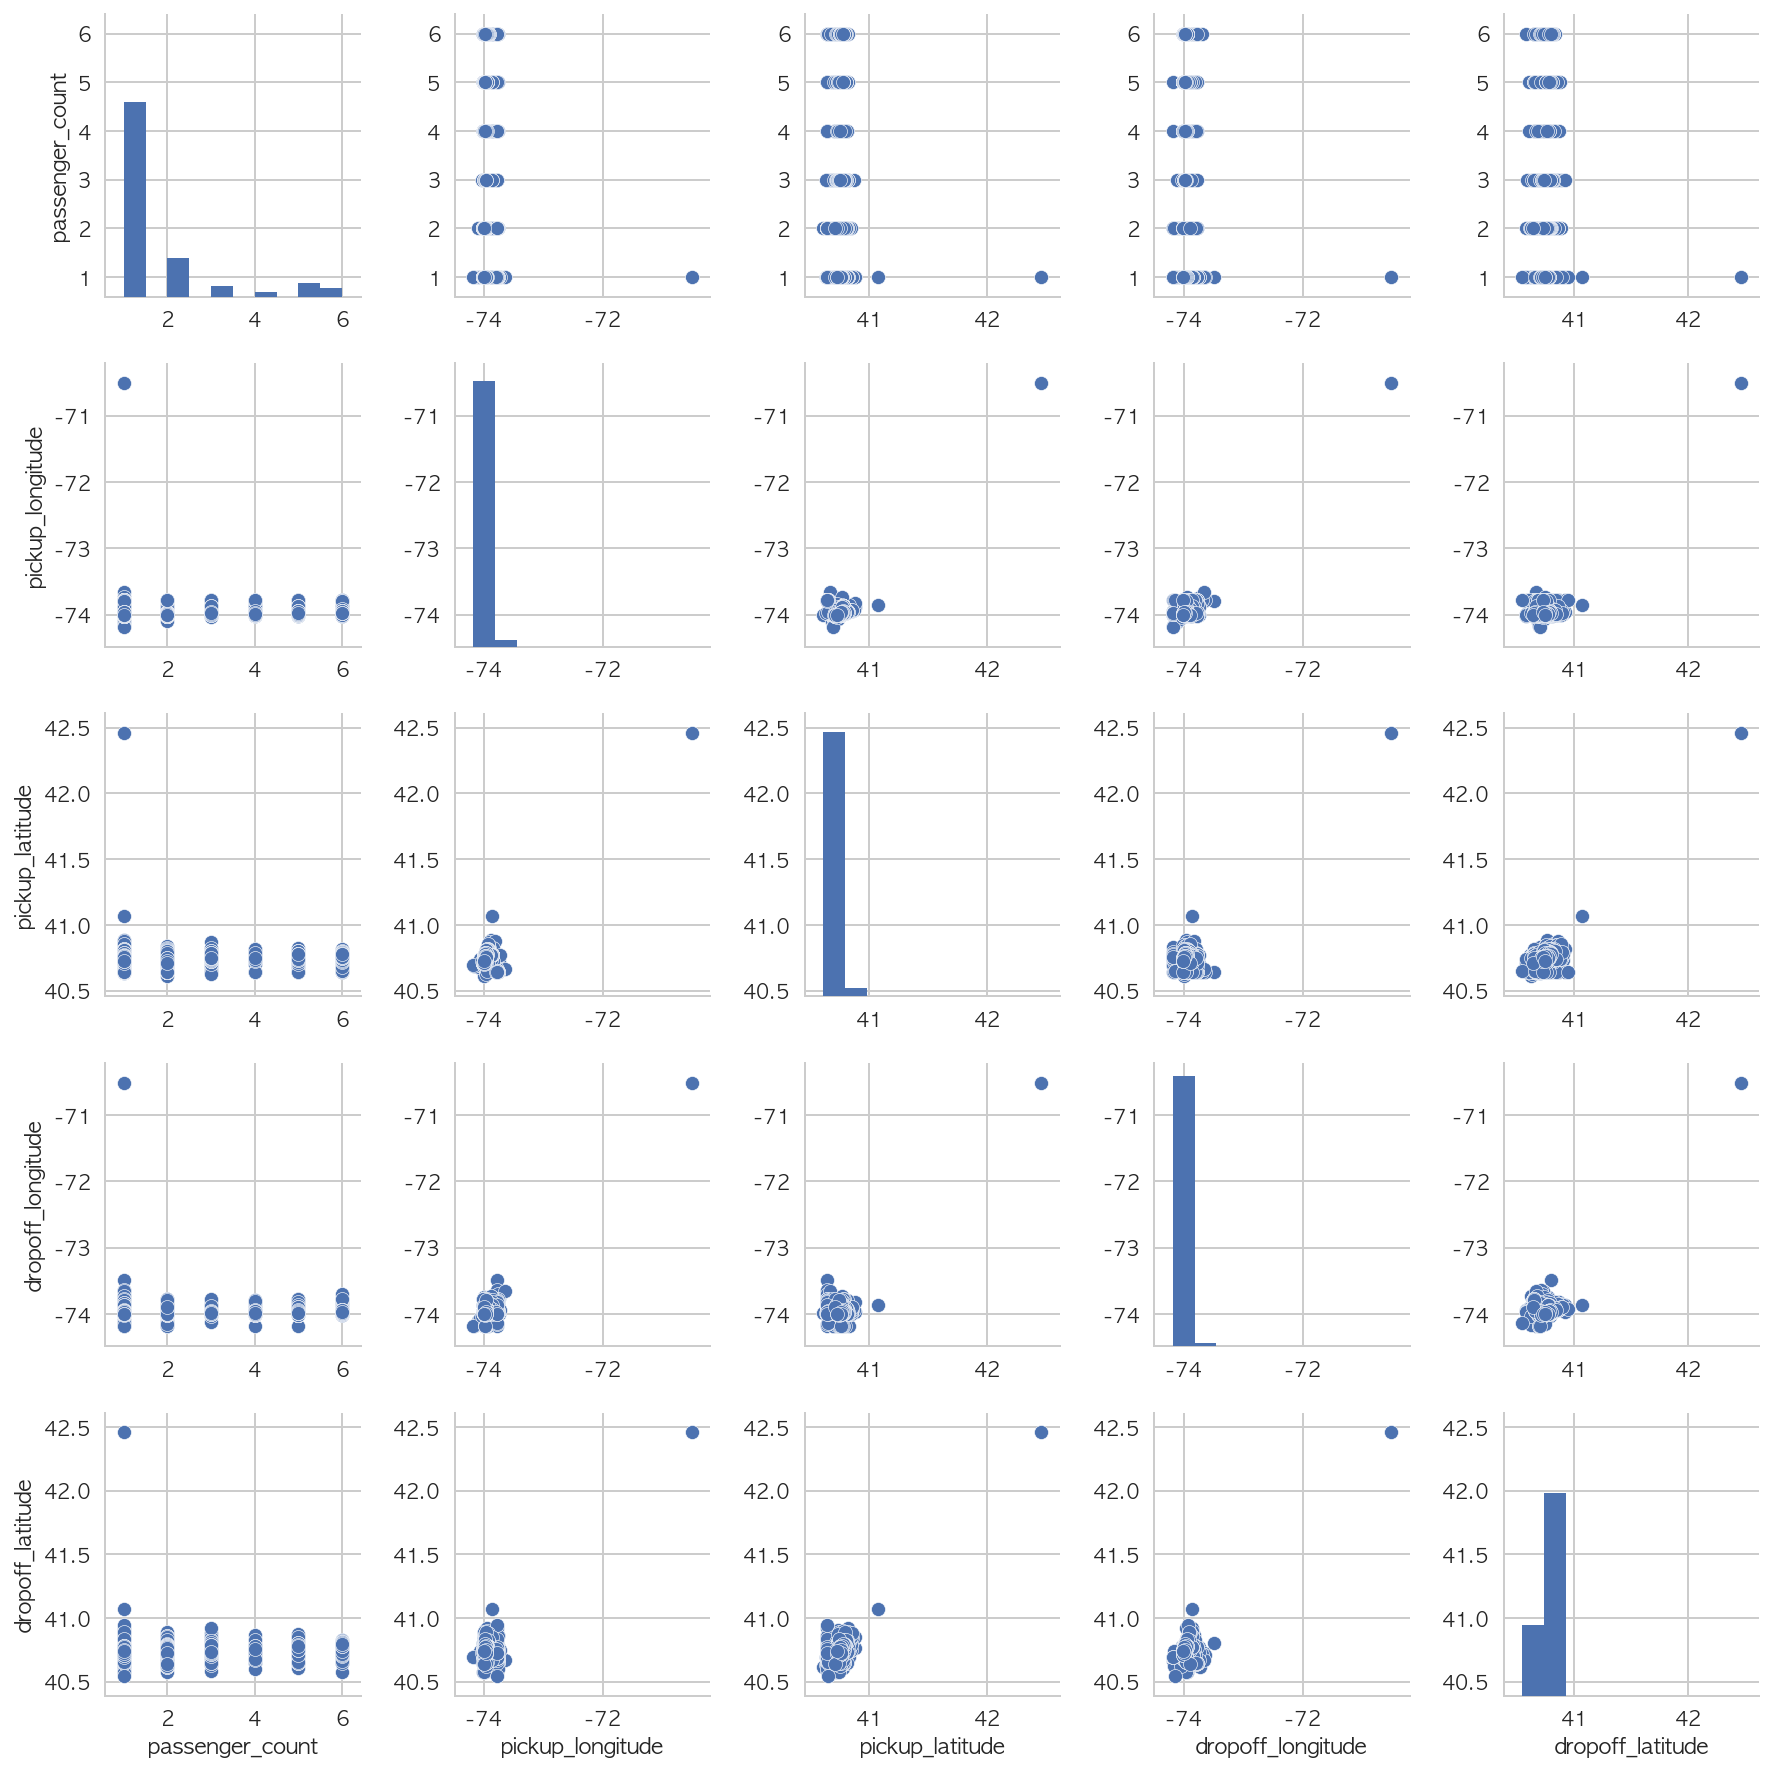

In [12]:
sns.pairplot(train_real_sample)
plt.show()

In [13]:
model = sm.OLS.from_formula("trip_duration ~ passenger_count", train)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     104.7
Date:                Wed, 07 Mar 2018   Prob (F-statistic):           1.44e-24
Time:                        15:24:45   Log-Likelihood:            -1.4561e+07
No. Observations:             1458644   AIC:                         2.912e+07
Df Residuals:                 1458642   BIC:                         2.912e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         903.3010      6.998    1

In [14]:
pickup_lat = tuple(train["pickup_latitude"])
pickup_lng = tuple(train["pickup_longitude"])
dropoff_lat = tuple(train["dropoff_latitude"])
dropoff_lng = tuple(train["dropoff_longitude"])

In [15]:
pickup_loc = tuple(zip(pickup_lat, pickup_lng))
dropoff_loc = tuple(zip(dropoff_lat, dropoff_lng))

In [16]:
len(pickup_loc), len(dropoff_loc)

(1458644, 1458644)

In [17]:
distance = []
for i in range(len(pickup_loc)):
    distance.append(haversine(pickup_loc[i], dropoff_loc[i]))

In [18]:
train["distance"] = distance

In [19]:
len(distance)

1458644

In [20]:
model = sm.OLS.from_formula("trip_duration ~ distance", train)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                 1.322e+04
Date:                Wed, 07 Mar 2018   Prob (F-statistic):               0.00
Time:                        15:24:54   Log-Likelihood:            -1.4554e+07
No. Observations:             1458644   AIC:                         2.911e+07
Df Residuals:                 1458642   BIC:                         2.911e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    561.9630      5.531    101.607      0.0

In [21]:
# fig = sm.graphics.plot_regress_exog(result, "distance")
# fig.set_size_inches(8, 5)
# fig.suptitle("")
# fig.tight_layout()
# plt.show()

In [22]:
influence = result.get_influence()
hat = influence.hat_matrix_diag

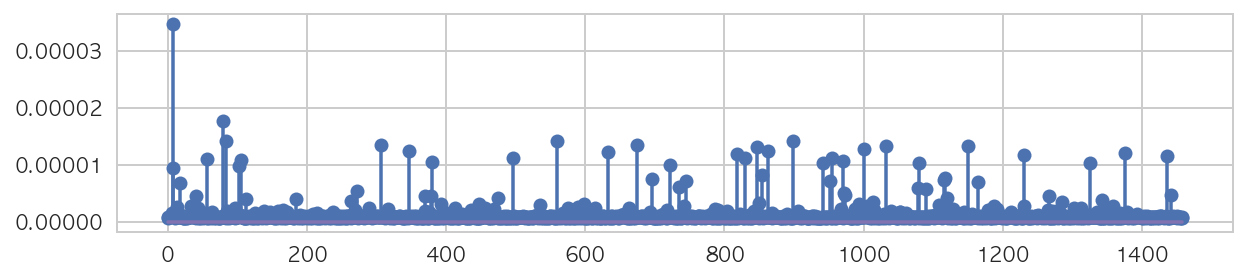

In [23]:
plt.figure(figsize=(10, 2))
plt.stem(hat[::1000])
plt.show()

In [24]:
# 평균 시속 구하기

train["avg_speed_h"] = 1000 * train["distance"] / train["trip_duration"]

In [25]:
train["avg_speed_h"].describe()

count    1.458644e+06
mean     4.006447e+00
std      4.160423e+00
min      0.000000e+00
25%      2.533687e+00
50%      3.553327e+00
75%      4.956920e+00
max      2.576344e+03
Name: avg_speed_h, dtype: float64

In [26]:
train_speed_duration = train[["trip_duration", "avg_speed_h"]]
train_speed_duration.tail()

,trip_duration,avg_speed_h
1458639,778,1.574653
1458640,655,9.236390
1458641,764,10.241631
1458642,373,2.929126
1458643,198,5.727485


In [27]:
# 평균 시속과 trip_duration을 각각 정규화한 뒤, pickup_hour로 groupby.mean()

mean_duration = train_speed_duration["trip_duration"].mean()
std_duration = train_speed_duration["trip_duration"].std()

mean_speed = train_speed_duration["avg_speed_h"].mean()
std_speed = train_speed_duration["avg_speed_h"].std()

train_sp_du_normalized = pd.DataFrame()

train_sp_du_normalized["trip_duration"] = (train_speed_duration["trip_duration"] - mean_duration) / std_duration
train_sp_du_normalized["avg_speed_h"] = (train_speed_duration["avg_speed_h"] - mean_speed) / std_speed
train_sp_du_normalized["pickup_hour"] = train["pickup_hour"]

train_sp_du_norm_groupby = train_sp_du_normalized.groupby("pickup_hour").mean()
train_sp_du_norm_groupby.tail()

,trip_duration,avg_speed_h
pickup_hour,,
19,-0.012437,-0.056432
20,-0.015281,0.062490
21,-0.013169,0.091267
22,0.012213,0.103436
23,-0.006568,0.162511


In [28]:
len(train_sp_du_normalized["trip_duration"])

1458644

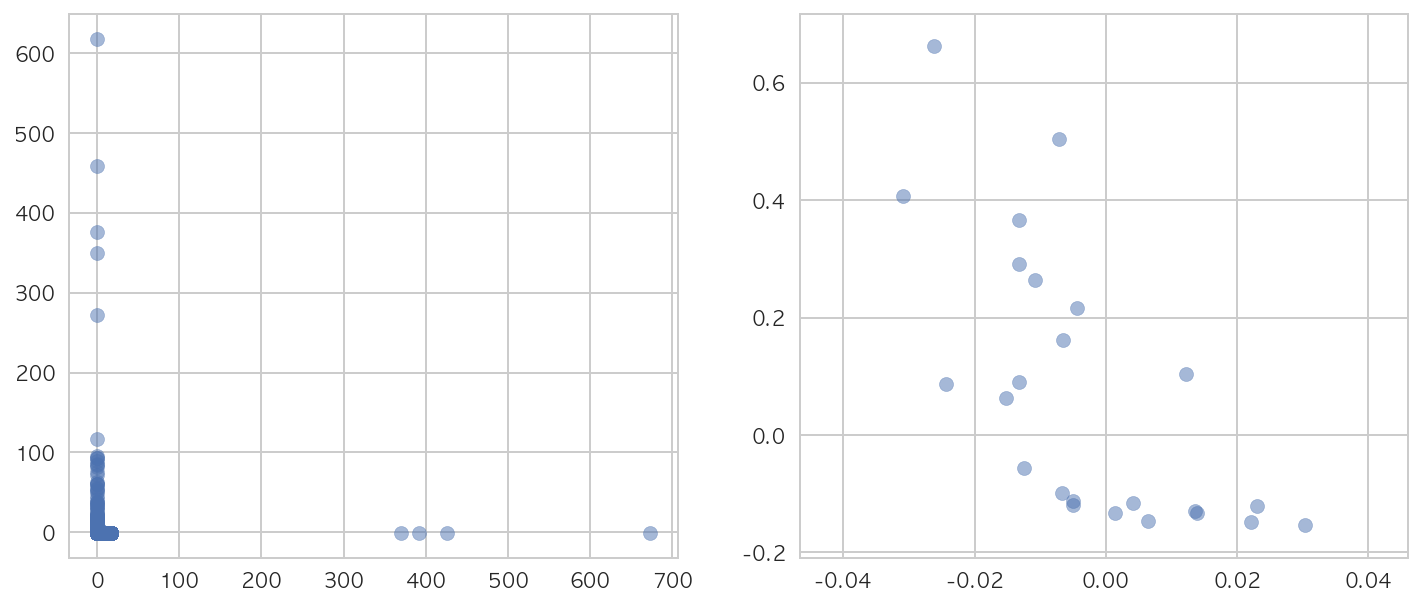

In [29]:
# groupby를 진행한 뒤를 살펴보면 speed가 증가할수록 trip_duration은 낮아짐을 보임
# groupby 전 데이터에는 여전히 아웃라이어가 많아 많은 영향을 받고 있음

plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.scatter(x="trip_duration", 
            y="avg_speed_h", data=train_sp_du_normalized, alpha=.5)

plt.subplot(122)
plt.scatter(x="trip_duration", 
            y="avg_speed_h", data=train_sp_du_norm_groupby, alpha=.5)

plt.show()

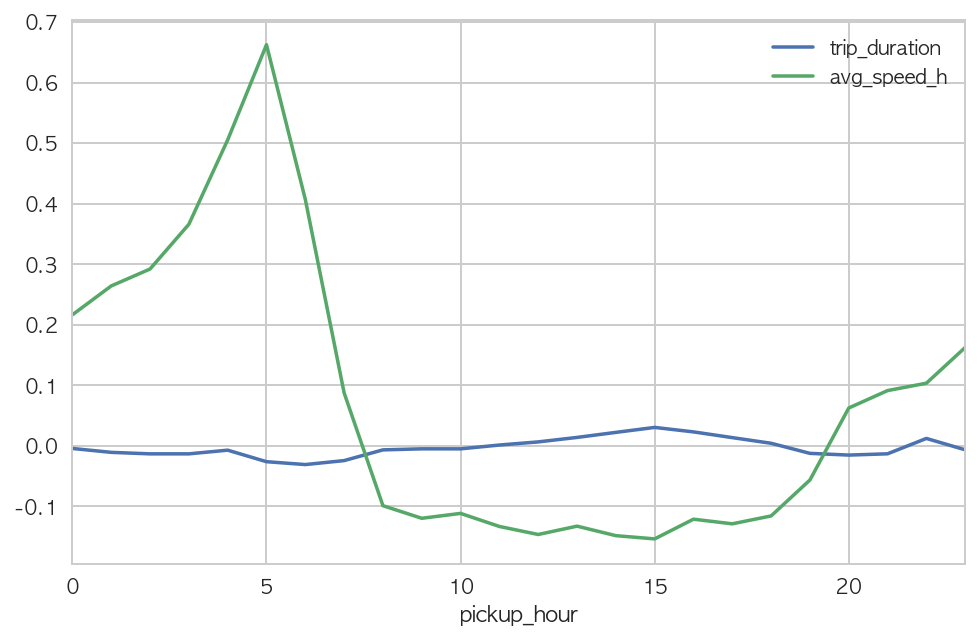

In [30]:
# 선 그래프로 보면 상관관계가 더 명확히 보임

train_sp_du_norm_groupby.plot(figsize=(8, 5))
plt.show()

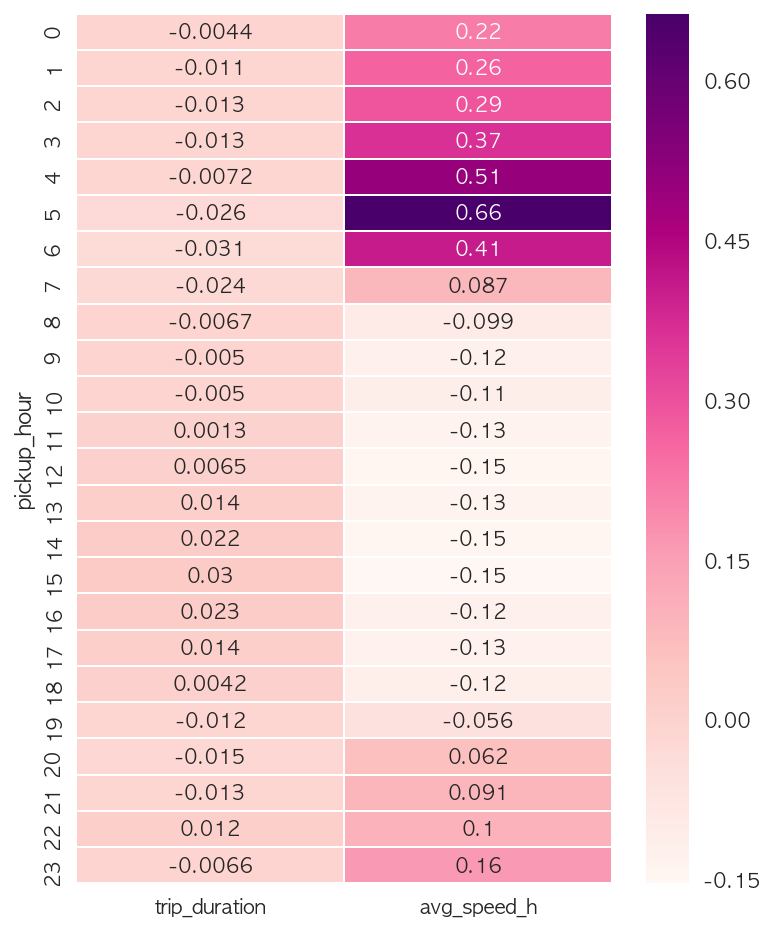

In [31]:
# heatmap으로 살펴보면 speed는 새벽에 가장 높으며, 출근시간부터 퇴근시간까지 계속해서 낮은 모습을 보임
# 이 기간엔 trip_duration도 상대적으로 조금 높아지는 모습을 보임

plt.figure(figsize=(6, 8))
sns.heatmap(train_sp_du_norm_groupby, cmap="RdPu", annot=True, linewidths=.5)
plt.show()

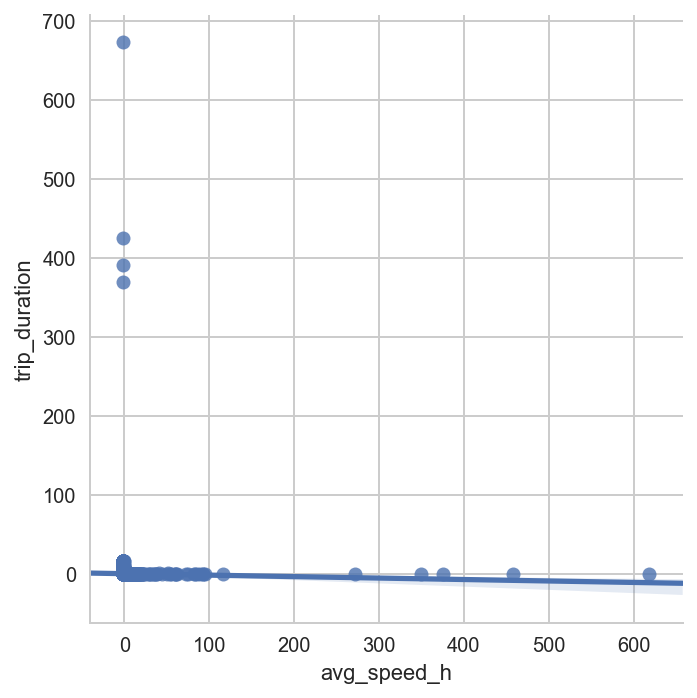

In [75]:
# 아웃라이어가 많음

plt.figure(figsize=(7, 5))
sns.lmplot(x="avg_speed_h", y="trip_duration", data=train_sp_du_normalized)
plt.show()

In [76]:
# trip_duration 정규화 값이 300 넘는 데이터 4개 식별

train_sp_du_normalized[train_sp_du_normalized["trip_duration"] > 300]

,trip_duration,avg_speed_h,pickup_hour
355003,370.176951,-0.960493,0
680594,391.149444,-0.962289,22
924150,425.142059,-0.962814,6
978383,673.101377,-0.961634,22


In [94]:
idx = np.where(train_sp_du_normalized["trip_duration"] > 300)
idx

(array([355003, 680594, 924150, 978383]),)

In [100]:
# trip_duration 정규화 값이 300 넘는 데이터 4개 제거

print(len(train_sp_du_normalized))
train_sp_du_normalized.drop(idx, inplace=True)
print(len(train_sp_du_normalized))

1458644
1458640


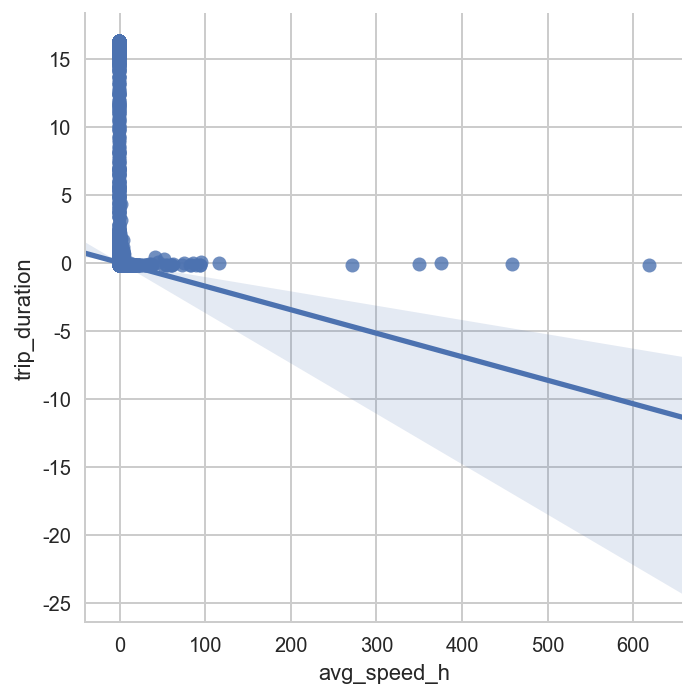

In [120]:
# 제거 후 lmplot: 여전히 분포는 예쁘지 않음

plt.figure(figsize=(7, 5))
sns.lmplot(x="avg_speed_h", y="trip_duration", data=train_sp_du_normalized)
plt.show()

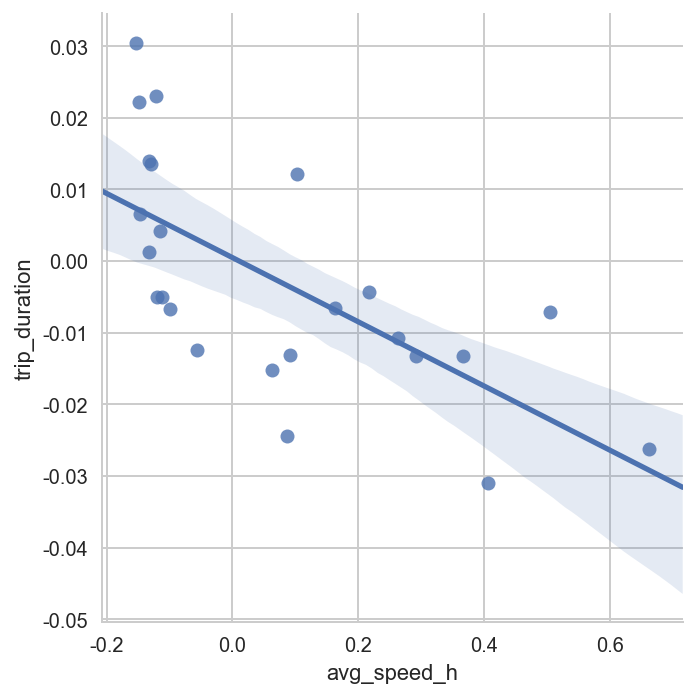

In [102]:
# groupby lmplot: 음의 상관관계를 보임

plt.figure(figsize=(7, 5))
sns.lmplot(x="avg_speed_h", y="trip_duration", data=train_sp_du_norm_groupby)
plt.show()

In [32]:
model = sm.OLS.from_formula("trip_duration ~ avg_speed_h", train_sp_du_normalized)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     499.8
Date:                Wed, 07 Mar 2018   Prob (F-statistic):          1.08e-110
Time:                        15:25:37   Log-Likelihood:            -2.0695e+06
No. Observations:             1458644   AIC:                         4.139e+06
Df Residuals:                 1458642   BIC:                         4.139e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -9.106e-16      0.001   -1.1e-12      

In [33]:
influence = result.get_influence()
hat = influence.hat_matrix_diag

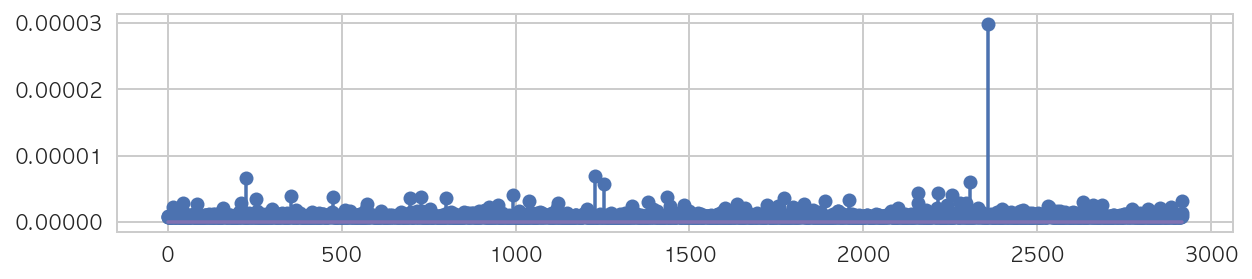

In [34]:
# 500개 간격으로 아웃라이어 살펴보기

plt.figure(figsize=(10, 2))
plt.stem(hat[::500])
plt.show()

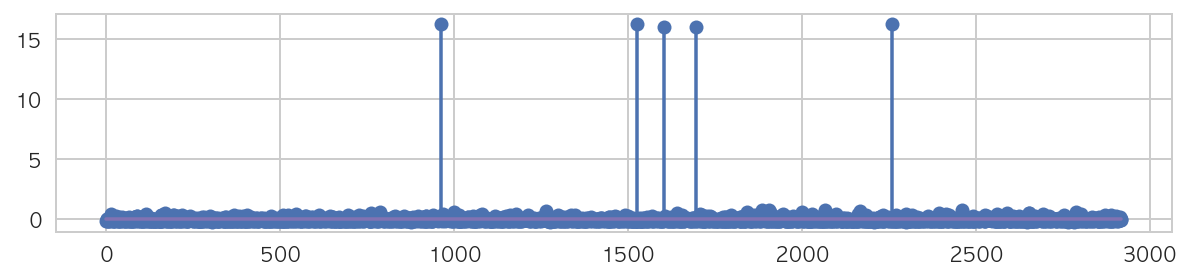

In [35]:
# 명백한 아웃라이어 3개 발견

plt.figure(figsize=(10, 2))
plt.stem(result.resid_pearson[::500])
plt.show()

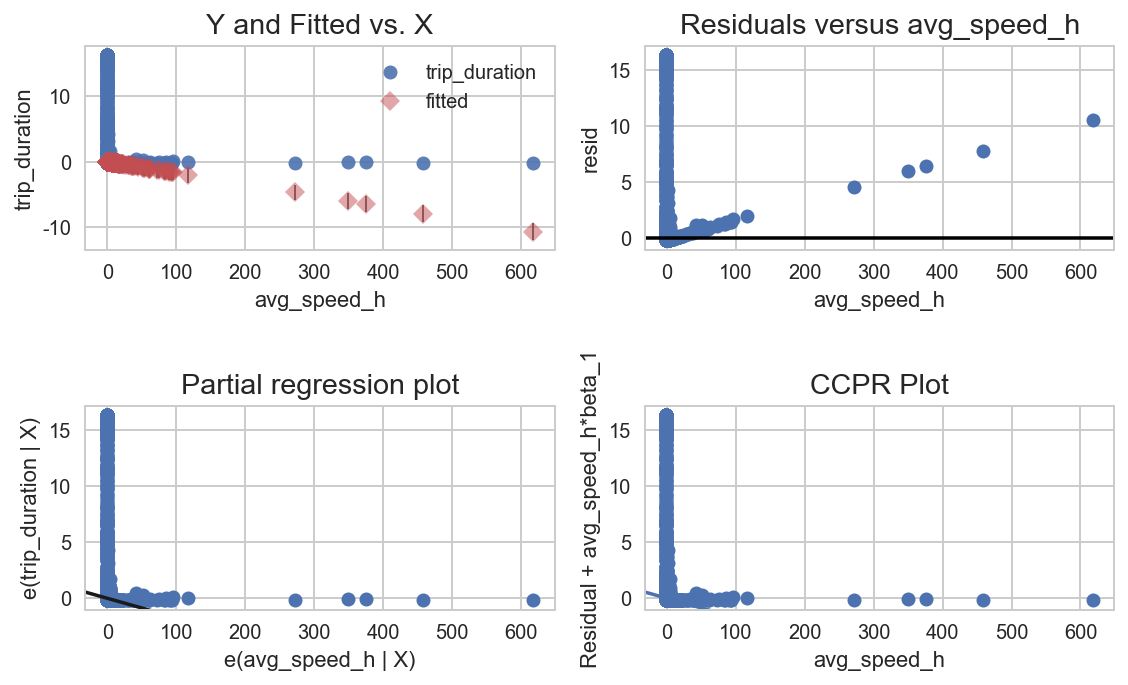

In [108]:
fig = sm.graphics.plot_regress_exog(result, "avg_speed_h")
fig.set_size_inches(8, 5)
fig.suptitle("")
fig.tight_layout()
plt.show()

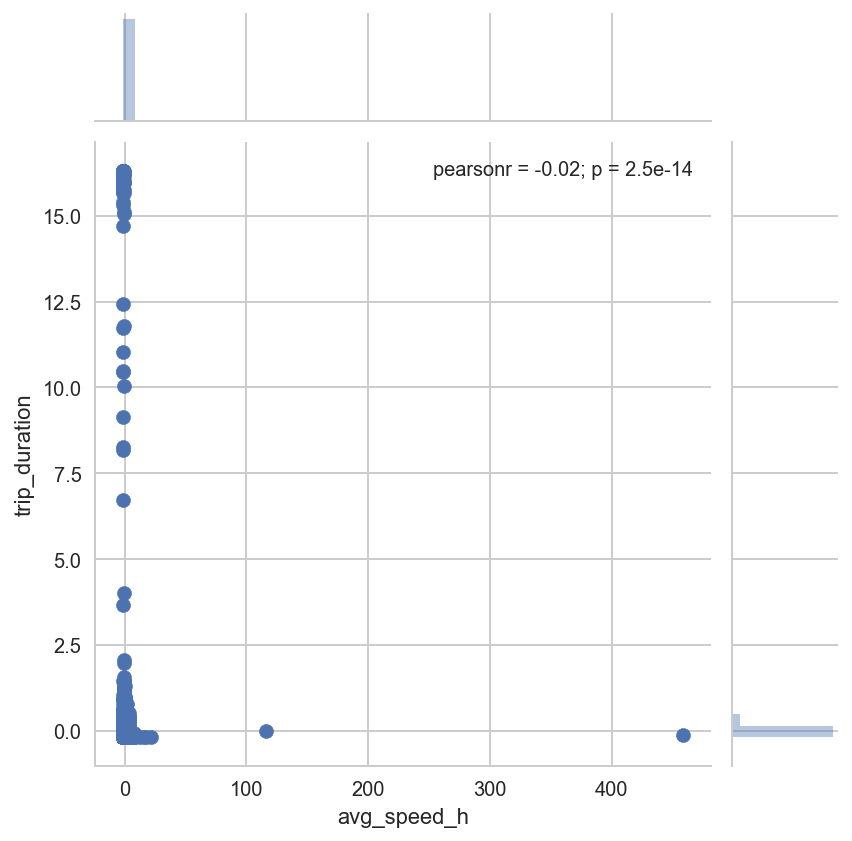

In [115]:
plt.figure(figsize=(7, 5))
sns.jointplot(x="avg_speed_h", y="trip_duration", data=train_sp_du_normalized[::10])
plt.show()

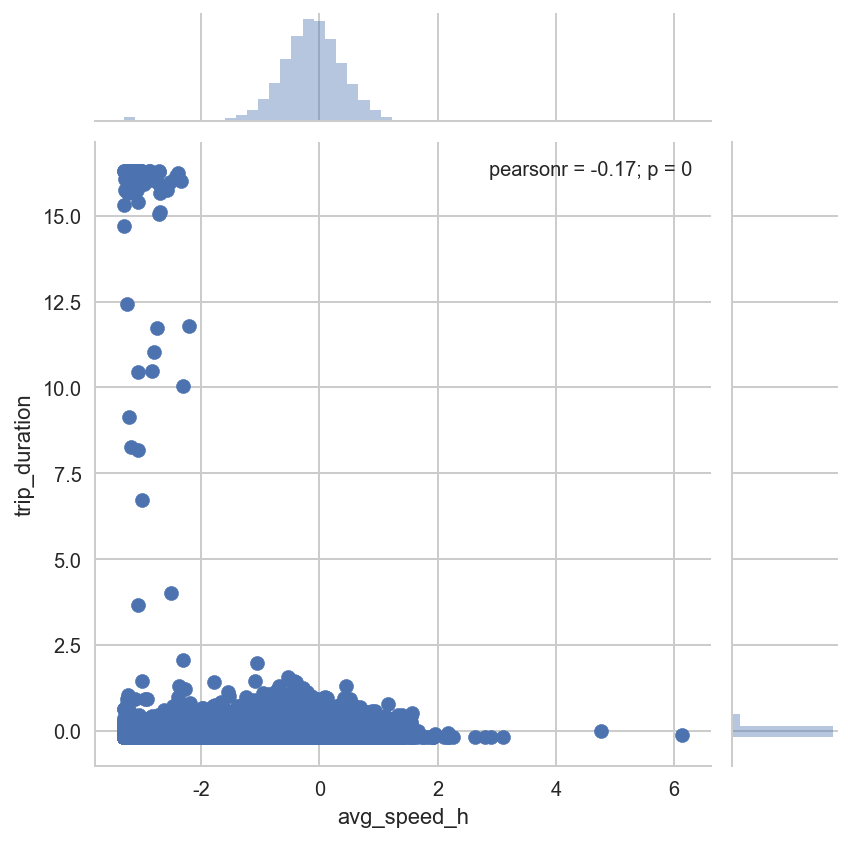

In [117]:
# trip_duration에 로그를 취해보면 아웃라이어가 몰려있음을 확인할 수 있음

plt.figure(figsize=(7, 5))
sns.jointplot(x=np.log1p(train_sp_du_normalized["avg_speed_h"]),
              y="trip_duration", 
              data=train_sp_du_normalized[::10])
plt.show()

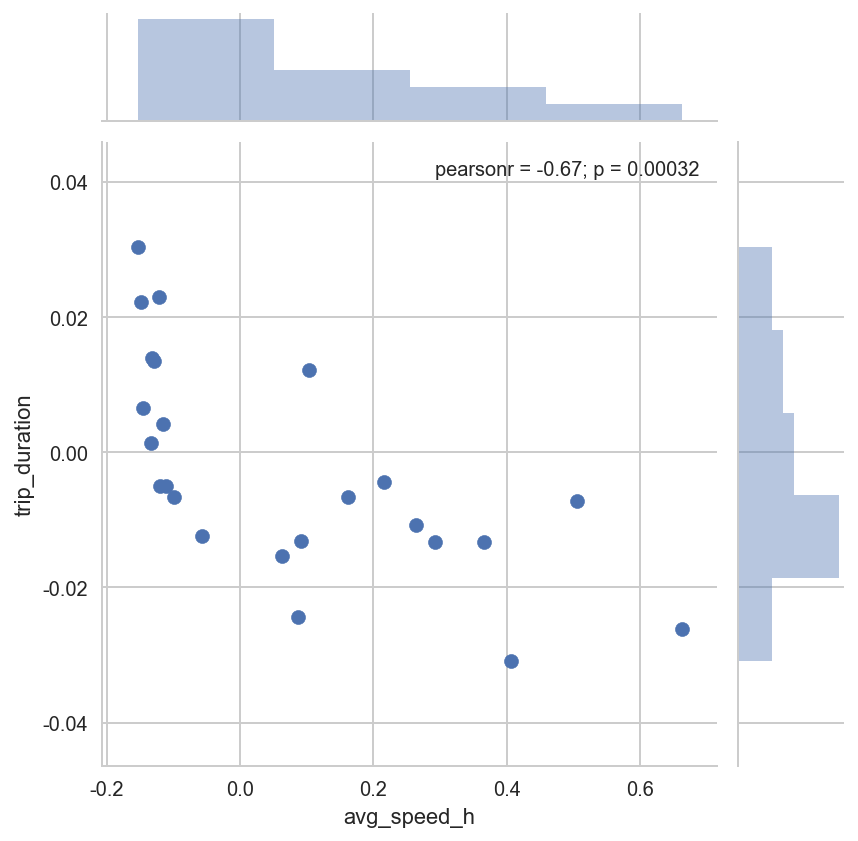

In [110]:
plt.figure(figsize=(7, 5))
sns.jointplot(x="avg_speed_h", y="trip_duration", data=train_sp_du_norm_groupby)
plt.show()

In [36]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 21 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null datetime64[ns]
dropoff_datetime      1458644 non-null datetime64[ns]
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
pickup_date           1458644 non-null object
dropoff_date          1458644 non-null object
pickup_month          1458644 non-null int64
dropoff_month         1458644 non-null int64
pickup_weekday        1458644 non-null int64
dropoff_weekday       1458644 non-null int64
pickup_hour           1458644 non-null int64
dropoff_hour          1458644 non-null int64
di

In [43]:
model = sm.OLS.from_formula("trip_duration ~ passenger_count +  distance + avg_speed_h+ C(pickup_hour)", train)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     829.3
Date:                Wed, 07 Mar 2018   Prob (F-statistic):               0.00
Time:                        15:38:34   Log-Likelihood:            -1.4550e+07
No. Observations:             1458644   AIC:                         2.910e+07
Df Residuals:                 1458617   BIC:                         2.910e+07
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              743.4163 

- 실수값: passenger_count, distance, avg_speed_h
### 1. 실수값 + 카테고리 pickup_hour

In [42]:
model = sm.OLS.from_formula("trip_duration ~ passenger_count +  distance + avg_speed_h+ C(pickup_hour) + 0", train)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     829.3
Date:                Wed, 07 Mar 2018   Prob (F-statistic):               0.00
Time:                        15:36:59   Log-Likelihood:            -1.4550e+07
No. Observations:             1458644   AIC:                         2.910e+07
Df Residuals:                 1458617   BIC:                         2.910e+07
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
C(pickup_hour)[0]    743.4163     23

### 2. 실수값 + 카테고리 (pickup_weekday)

In [44]:
model = sm.OLS.from_formula("trip_duration ~ passenger_count +  distance + avg_speed_h+ C(pickup_weekday) + 0", train)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     2386.
Date:                Wed, 07 Mar 2018   Prob (F-statistic):               0.00
Time:                        15:40:32   Log-Likelihood:            -1.4550e+07
No. Observations:             1458644   AIC:                         2.910e+07
Df Residuals:                 1458634   BIC:                         2.910e+07
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
C(pickup_weekday)[0]   707.0599 

### 3. 실수값 + 카테고리(pickup_month)

In [45]:
model = sm.OLS.from_formula("trip_duration ~ passenger_count +  distance + avg_speed_h+ C(pickup_month) + 0", train)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     2680.
Date:                Wed, 07 Mar 2018   Prob (F-statistic):               0.00
Time:                        15:42:10   Log-Likelihood:            -1.4550e+07
No. Observations:             1458644   AIC:                         2.910e+07
Df Residuals:                 1458635   BIC:                         2.910e+07
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
C(pickup_month)[1]   753.6576     12

### 4. 실수값 + 카테고리 (pickup_hour + pickup_weekday)

In [46]:
model = sm.OLS.from_formula("trip_duration ~\
                            passenger_count +  distance + avg_speed_h+ C(pickup_hour + pickup_weekday) + 0", train)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     672.8
Date:                Wed, 07 Mar 2018   Prob (F-statistic):               0.00
Time:                        15:54:03   Log-Likelihood:            -1.4550e+07
No. Observations:             1458644   AIC:                         2.910e+07
Df Residuals:                 1458611   BIC:                         2.910e+07
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
C(

### 5. 실수값 + 카테고리 (pickup_hour + pickup_month)

In [47]:
model = sm.OLS.from_formula("trip_duration ~\
                            passenger_count +  distance + avg_speed_h+ C(pickup_hour + pickup_month) + 0", train)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     694.2
Date:                Wed, 07 Mar 2018   Prob (F-statistic):               0.00
Time:                        15:55:29   Log-Likelihood:            -1.4550e+07
No. Observations:             1458644   AIC:                         2.910e+07
Df Residuals:                 1458612   BIC:                         2.910e+07
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
C(pick

### 6. 실수값 + 카테고리 ( pickup_weekday + pickup_month)

In [48]:
model = sm.OLS.from_formula("trip_duration ~\
                            passenger_count +  distance + avg_speed_h+ C(pickup_weekday + pickup_month) + 0", train)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     1534.
Date:                Wed, 07 Mar 2018   Prob (F-statistic):               0.00
Time:                        15:56:17   Log-Likelihood:            -1.4550e+07
No. Observations:             1458644   AIC:                         2.910e+07
Df Residuals:                 1458629   BIC:                         2.910e+07
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


### 7. 실수값 + 카테고리 ( pickup_hour + pickup_weekday + pickup_month)

In [49]:
model = sm.OLS.from_formula("trip_duration ~\
                            passenger_count +  distance + avg_speed_h+\
                            C(pickup_hour + pickup_weekday + pickup_month) + 0", train)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     582.1
Date:                Wed, 07 Mar 2018   Prob (F-statistic):               0.00
Time:                        15:57:16   Log-Likelihood:            -1.4550e+07
No. Observations:             1458644   AIC:                         2.910e+07
Df Residuals:                 1458606   BIC:                         2.910e+07
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

### 8. 실수값 + pickup_hour (실수)

In [50]:
model = sm.OLS.from_formula("trip_duration ~ passenger_count +  distance + avg_speed_h + pickup_hour", train)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     5356.
Date:                Wed, 07 Mar 2018   Prob (F-statistic):               0.00
Time:                        15:59:36   Log-Likelihood:            -1.4550e+07
No. Observations:             1458644   AIC:                         2.910e+07
Df Residuals:                 1458639   BIC:                         2.910e+07
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         754.4668     12.442     

### 9. 실수값 + pickup_weekday (실수)

In [51]:
model = sm.OLS.from_formula("trip_duration ~ passenger_count +  distance + avg_speed_h + pickup_weekday", train)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     5356.
Date:                Wed, 07 Mar 2018   Prob (F-statistic):               0.00
Time:                        16:00:40   Log-Likelihood:            -1.4550e+07
No. Observations:             1458644   AIC:                         2.910e+07
Df Residuals:                 1458639   BIC:                         2.910e+07
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         761.0913     10.474     

### 10. 실수값 + pickup_month (실수)

In [52]:
model = sm.OLS.from_formula("trip_duration ~ passenger_count +  distance + avg_speed_h + pickup_month", train)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     5359.
Date:                Wed, 07 Mar 2018   Prob (F-statistic):               0.00
Time:                        16:01:17   Log-Likelihood:            -1.4550e+07
No. Observations:             1458644   AIC:                         2.910e+07
Df Residuals:                 1458639   BIC:                         2.910e+07
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         735.0958     12.241     

### 11. 실수값 + pickup_hour + pickup_weekday (실수)

In [53]:
model = sm.OLS.from_formula("trip_duration ~ passenger_count + distance + avg_speed_h +\
                            pickup_hour + pickup_weekday", train)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     4285.
Date:                Wed, 07 Mar 2018   Prob (F-statistic):               0.00
Time:                        16:05:02   Log-Likelihood:            -1.4550e+07
No. Observations:             1458644   AIC:                         2.910e+07
Df Residuals:                 1458638   BIC:                         2.910e+07
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         743.7060     14.403     

### 12. 실수값 + pickup_weekday + pickup_month (실수)

In [54]:
model = sm.OLS.from_formula("trip_duration ~ passenger_count + distance + avg_speed_h +\
                            pickup_weekday + pickup_month", train)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     4288.
Date:                Wed, 07 Mar 2018   Prob (F-statistic):               0.00
Time:                        16:07:16   Log-Likelihood:            -1.4550e+07
No. Observations:             1458644   AIC:                         2.910e+07
Df Residuals:                 1458638   BIC:                         2.910e+07
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         725.9132     13.899     

### 13. 실수값 + pickup_hour + pickup_weekday + pickup_month (실수)

In [55]:
model = sm.OLS.from_formula("trip_duration ~ passenger_count + distance + avg_speed_h +\
                            pickup_hour + pickup_weekday + pickup_month", train)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     3574.
Date:                Wed, 07 Mar 2018   Prob (F-statistic):               0.00
Time:                        16:07:48   Log-Likelihood:            -1.4550e+07
No. Observations:             1458644   AIC:                         2.910e+07
Df Residuals:                 1458637   BIC:                         2.910e+07
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         708.2173     17.086     

### 14. 실수값 + 카테고리 (vendor_id)

In [58]:
model = sm.OLS.from_formula("trip_duration ~ passenger_count + distance + avg_speed_h + C(vendor_id) + 0", train)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     5479.
Date:                Wed, 07 Mar 2018   Prob (F-statistic):               0.00
Time:                        16:12:02   Log-Likelihood:            -1.4550e+07
No. Observations:             1458644   AIC:                         2.910e+07
Df Residuals:                 1458639   BIC:                         2.910e+07
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
C(vendor_id)[1]   699.8506      8.831     

### 15. 실수값 + 카테고리 (store_and_fwd_flag)

In [59]:
model = sm.OLS.from_formula("trip_duration ~ passenger_count + distance + avg_speed_h +\
                            C(store_and_fwd_flag) + 0", train)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     5356.
Date:                Wed, 07 Mar 2018   Prob (F-statistic):               0.00
Time:                        16:13:17   Log-Likelihood:            -1.4550e+07
No. Observations:             1458644   AIC:                         2.910e+07
Df Residuals:                 1458639   BIC:                         2.910e+07
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
C(store_and_fwd_flag)[N]

In [71]:
train["store_and_fwd_flag"] = 1 * (train.store_and_fwd_flag.values == 'Y')

In [72]:
train["store_and_fwd_flag"].head()

0    0
1    0
2    0
3    0
4    0
Name: store_and_fwd_flag, dtype: int64

### 16. 실수값 + 카테고리 (vendor_id, store_and_fwd_flag)

In [75]:
model = sm.OLS.from_formula("trip_duration ~ passenger_count + distance + avg_speed_h +\
                            C(vendor_id + store_and_fwd_flag) + 0", train)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     5479.
Date:                Wed, 07 Mar 2018   Prob (F-statistic):               0.00
Time:                        16:33:21   Log-Likelihood:            -1.4550e+07
No. Observations:             1458644   AIC:                         2.910e+07
Df Residuals:                 1458639   BIC:                         2.910e+07
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


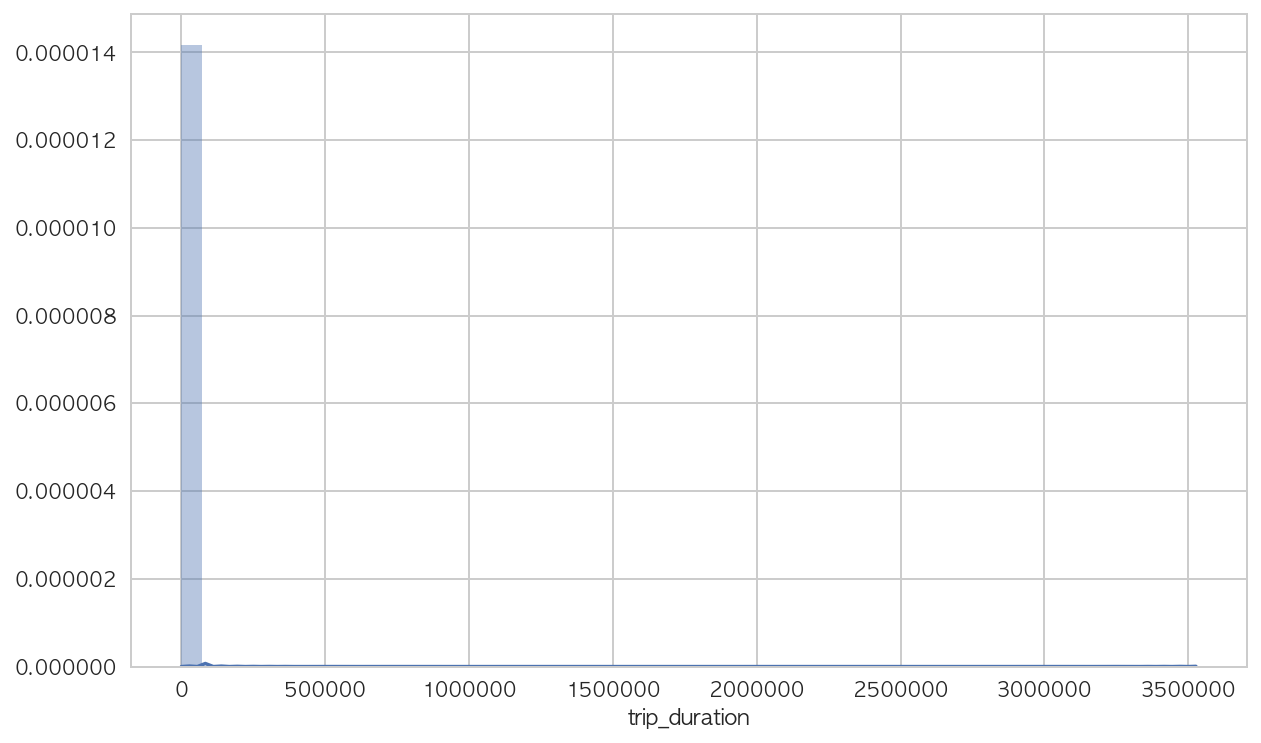

In [81]:
plt.figure(figsize=(10, 6))
sns.distplot(train["trip_duration"])
plt.show()